#Importing Dataset

In [ ]:
! kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 1.28G/1.28G [01:01<00:00, 22.5MB/s]
100% 1.28G/1.28G [01:01<00:00, 22.3MB/s]


In [ ]:
!rm -rf fruits-360*
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

#Importing libraries

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks

In [ ]:
# load dataset
train_dir = '/content/fruits-360_dataset/fruits-360/Training'
test_dir = '/content/fruits-360_dataset/fruits-360/Test'

# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=8,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=8,
    image_size=(224, 224),
    seed=42,
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [ ]:
# Get the class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_dir))

# Print the class names and the number of classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Mar

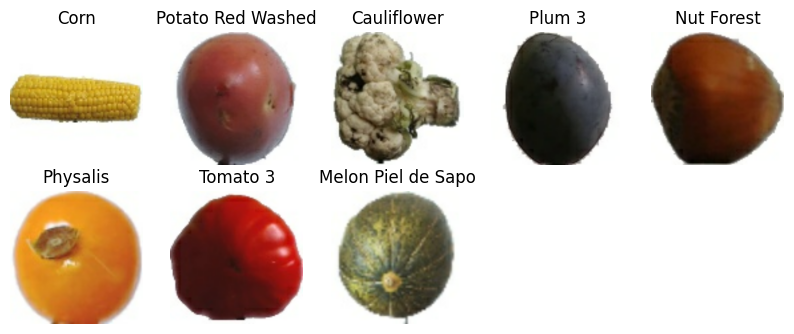

In [ ]:
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(8):  # Display 25 images
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Show images from training dataset
show_images(train_ds, class_names)
plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.shuffle(128)
val_ds = val_ds

##Data Augmentation

In [ ]:
# Augmentation for training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

#Building Model

In [ ]:
base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                             

##Train Model

In [ ]:
# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(patience=3)

# Train the model with early stopping
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the training process
)

Epoch 1/10
6770/6770 [==============================] - 125s 17ms/step - loss: 1.3761 - accuracy: 0.7366 - val_loss: 0.3930 - val_accuracy: 0.9738
Epoch 2/10
6770/6770 [==============================] - 115s 17ms/step - loss: 0.2232 - accuracy: 0.9725 - val_loss: 0.1390 - val_accuracy: 0.9916
Epoch 3/10
6770/6770 [==============================] - 112s 16ms/step - loss: 0.0948 - accuracy: 0.9900 - val_loss: 0.0680 - val_accuracy: 0.9976
Epoch 4/10
6770/6770 [==============================] - 110s 16ms/step - loss: 0.0536 - accuracy: 0.9945 - val_loss: 0.0417 - val_accuracy: 0.9984
Epoch 5/10
6770/6770 [==============================] - 111s 16ms/step - loss: 0.0348 - accuracy: 0.9970 - val_loss: 0.0281 - val_accuracy: 0.9990
Epoch 6/10
6770/6770 [==============================] - 111s 16ms/step - loss: 0.0258 - accuracy: 0.9972 - val_loss: 0.0205 - val_accuracy: 0.9994
Epoch 7/10
6770/6770 [==============================] - 110s 16ms/step - loss: 0.0198 - accuracy: 0.9979 - val_loss: 0

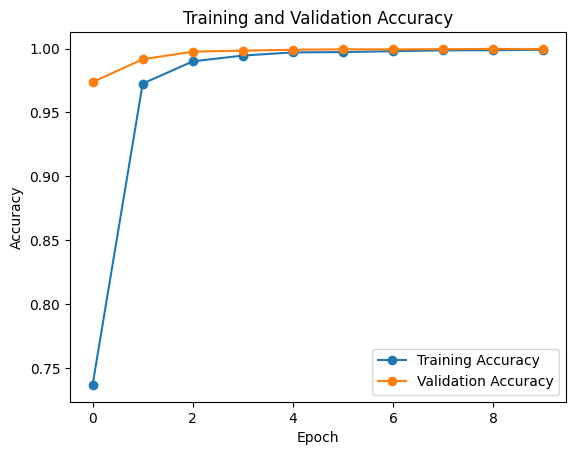

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

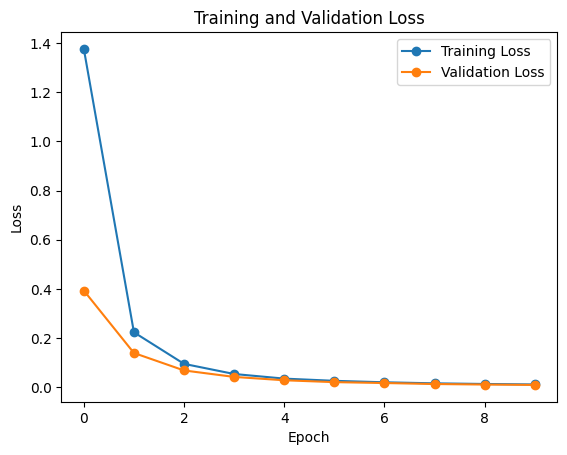

In [ ]:
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predictions = tf.nn.softmax(predictions)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


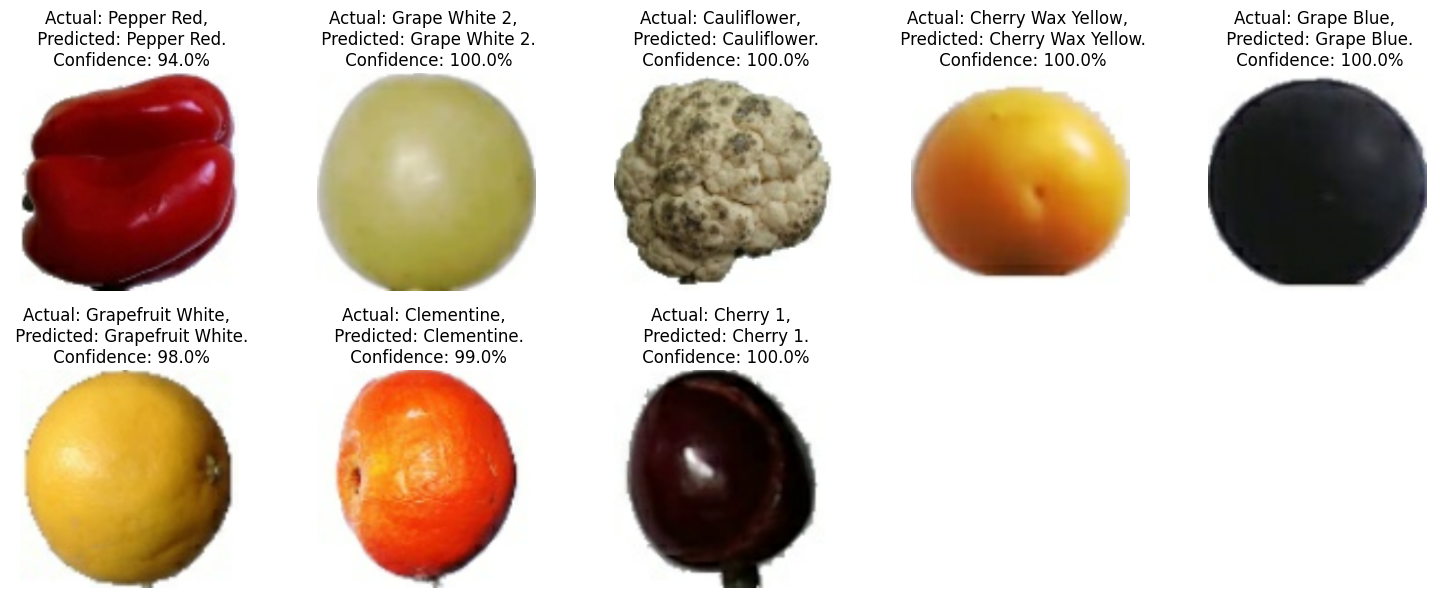

In [ ]:
import matplotlib.pyplot as plt

# Assuming val_ds is your validation dataset
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(5, 5, i+1)  # Adjust the subplot layout as per your preference
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save('model_capstone.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)